Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 2200 files belonging to 110 classes.
Using 1760 files for training.
Using 440 files for validation.

Total number of samples in train_dataset: 1408 (44 batches of 32)
Total number of samples in validation_dataset: 448 (14 batches of 32)
Total number of samples in test_dataset: 352 (11 batches of 32)


Prefetching data into GPU memory to optimize training process

In [4]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

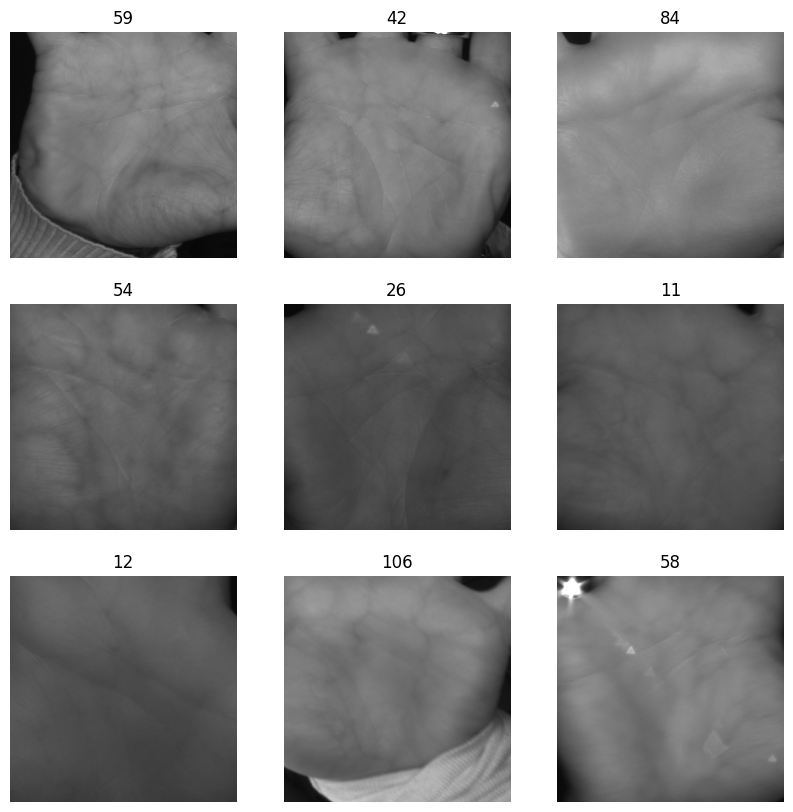

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Creating data augmentation layer 

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomHeight(0.1),
        layers.RandomWidth(0.1),
    ]
)

Visualizing the data augmentations on a random training image

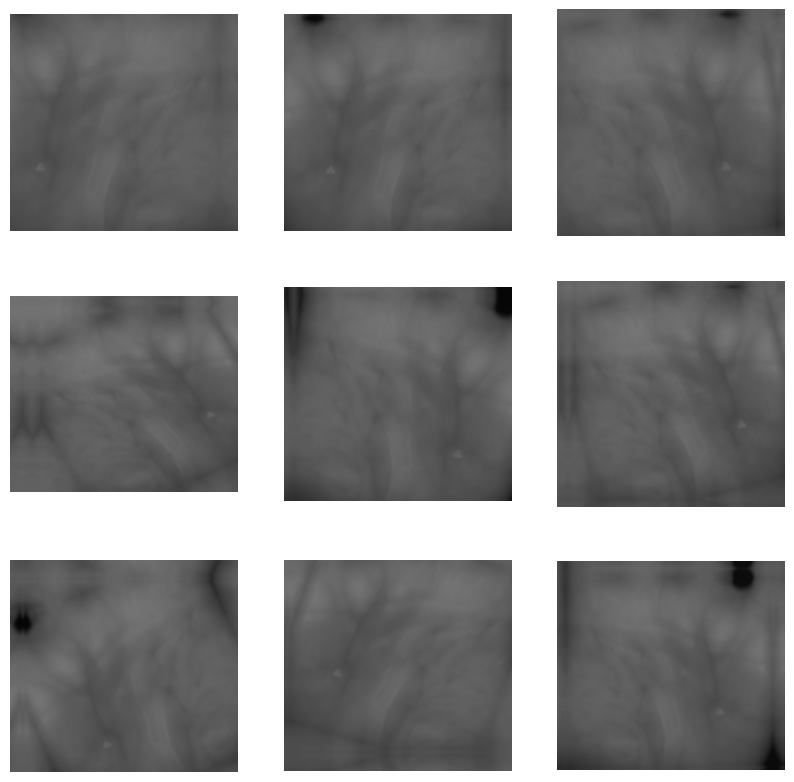

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Define some key constants

In [8]:
num_classes = 110
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [9]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [10]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [11]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [12]:
from tqdm import tqdm
num_epochs = 30

models = {
    "AlexNet": make_alexnet_model(input_shape=image_size, num_classes=num_classes),
    "VGG16": make_vgg16_model(input_shape=image_size, num_classes=num_classes),
    "VGG19": make_vgg19_model(input_shape=image_size, num_classes=num_classes),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
42/44 [===========================>..] - ETA: 0s - loss: 4.4889 - accuracy: 0.0327

  3%|▎         | 1/30 [00:21<10:37, 21.98s/it]

44/44 [==============================] - 22s 37ms/step - loss: 4.4742 - accuracy: 0.0327 - val_loss: 5.0985 - val_accuracy: 0.0045
Epoch 2/30
43/44 [============================>.] - ETA: 0s - loss: 3.7818 - accuracy: 0.1083

  7%|▋         | 2/30 [00:23<04:36,  9.89s/it]

44/44 [==============================] - 1s 29ms/step - loss: 3.7809 - accuracy: 0.1072 - val_loss: 4.9174 - val_accuracy: 0.0182
Epoch 3/30
43/44 [============================>.] - ETA: 0s - loss: 3.3672 - accuracy: 0.1708

 10%|█         | 3/30 [00:25<02:44,  6.11s/it]

44/44 [==============================] - 2s 33ms/step - loss: 3.3676 - accuracy: 0.1705 - val_loss: 4.3037 - val_accuracy: 0.0364
Epoch 4/30
43/44 [============================>.] - ETA: 0s - loss: 2.9819 - accuracy: 0.2471

 13%|█▎        | 4/30 [00:26<01:53,  4.35s/it]

44/44 [==============================] - 2s 34ms/step - loss: 2.9811 - accuracy: 0.2464 - val_loss: 3.5139 - val_accuracy: 0.1568
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 2.5786 - accuracy: 0.3487

 17%|█▋        | 5/30 [00:28<01:22,  3.31s/it]

44/44 [==============================] - 1s 30ms/step - loss: 2.5786 - accuracy: 0.3487 - val_loss: 3.1146 - val_accuracy: 0.2545
Epoch 6/30
42/44 [===========================>..] - ETA: 0s - loss: 2.2382 - accuracy: 0.4092

 20%|██        | 6/30 [00:29<01:04,  2.69s/it]

44/44 [==============================] - 1s 30ms/step - loss: 2.2416 - accuracy: 0.4091 - val_loss: 2.6634 - val_accuracy: 0.3636
Epoch 7/30
42/44 [===========================>..] - ETA: 0s - loss: 1.8579 - accuracy: 0.5037

 23%|██▎       | 7/30 [00:31<00:52,  2.30s/it]

44/44 [==============================] - 1s 30ms/step - loss: 1.8665 - accuracy: 0.5000 - val_loss: 2.7557 - val_accuracy: 0.2864
Epoch 8/30
42/44 [===========================>..] - ETA: 0s - loss: 1.5550 - accuracy: 0.5818

 27%|██▋       | 8/30 [00:32<00:44,  2.04s/it]

44/44 [==============================] - 1s 31ms/step - loss: 1.5648 - accuracy: 0.5781 - val_loss: 2.7066 - val_accuracy: 0.3205
Epoch 9/30
43/44 [============================>.] - ETA: 0s - loss: 1.2879 - accuracy: 0.6483

 30%|███       | 9/30 [00:34<00:39,  1.87s/it]

44/44 [==============================] - 1s 30ms/step - loss: 1.2780 - accuracy: 0.6513 - val_loss: 3.7885 - val_accuracy: 0.1795
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 1.0943 - accuracy: 0.7038

 33%|███▎      | 10/30 [00:35<00:34,  1.75s/it]

44/44 [==============================] - 1s 30ms/step - loss: 1.0943 - accuracy: 0.7038 - val_loss: 3.6267 - val_accuracy: 0.2409
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 0.9217 - accuracy: 0.7457

 37%|███▋      | 11/30 [00:37<00:31,  1.67s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.9217 - accuracy: 0.7457 - val_loss: 2.3582 - val_accuracy: 0.4386
Epoch 12/30
42/44 [===========================>..] - ETA: 0s - loss: 0.7441 - accuracy: 0.7976

 40%|████      | 12/30 [00:38<00:29,  1.64s/it]

44/44 [==============================] - 2s 32ms/step - loss: 0.7397 - accuracy: 0.7997 - val_loss: 3.4098 - val_accuracy: 0.3023
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.8430

 43%|████▎     | 13/30 [00:40<00:27,  1.60s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.5834 - accuracy: 0.8430 - val_loss: 3.2413 - val_accuracy: 0.3841
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.8629

 47%|████▋     | 14/30 [00:41<00:25,  1.58s/it]

44/44 [==============================] - 2s 31ms/step - loss: 0.5404 - accuracy: 0.8629 - val_loss: 1.9047 - val_accuracy: 0.6568
Epoch 15/30
43/44 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8924

 50%|█████     | 15/30 [00:43<00:23,  1.55s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.4370 - accuracy: 0.8892 - val_loss: 1.8178 - val_accuracy: 0.7182
Epoch 16/30
43/44 [============================>.] - ETA: 0s - loss: 0.2972 - accuracy: 0.9266

 53%|█████▎    | 16/30 [00:44<00:21,  1.53s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.2964 - accuracy: 0.9268 - val_loss: 2.1742 - val_accuracy: 0.6295
Epoch 17/30
42/44 [===========================>..] - ETA: 0s - loss: 0.2540 - accuracy: 0.9330

 57%|█████▋    | 17/30 [00:46<00:19,  1.51s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.2612 - accuracy: 0.9297 - val_loss: 2.2320 - val_accuracy: 0.6318
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.2221 - accuracy: 0.9396

 60%|██████    | 18/30 [00:47<00:17,  1.50s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.2221 - accuracy: 0.9396 - val_loss: 1.8565 - val_accuracy: 0.7500
Epoch 19/30
42/44 [===========================>..] - ETA: 0s - loss: 0.2011 - accuracy: 0.9531

 63%|██████▎   | 19/30 [00:49<00:16,  1.49s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.2015 - accuracy: 0.9531 - val_loss: 1.6624 - val_accuracy: 0.8091
Epoch 20/30
42/44 [===========================>..] - ETA: 0s - loss: 0.1797 - accuracy: 0.9665

 67%|██████▋   | 20/30 [00:50<00:14,  1.49s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.1877 - accuracy: 0.9638 - val_loss: 1.4899 - val_accuracy: 0.8409
Epoch 21/30
42/44 [===========================>..] - ETA: 0s - loss: 0.1354 - accuracy: 0.9658

 70%|███████   | 21/30 [00:52<00:13,  1.50s/it]

44/44 [==============================] - 2s 31ms/step - loss: 0.1398 - accuracy: 0.9638 - val_loss: 1.6399 - val_accuracy: 0.8318
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9716

 73%|███████▎  | 22/30 [00:53<00:11,  1.49s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.1062 - accuracy: 0.9716 - val_loss: 1.7770 - val_accuracy: 0.7886
Epoch 23/30
42/44 [===========================>..] - ETA: 0s - loss: 0.0871 - accuracy: 0.9777

 77%|███████▋  | 23/30 [00:55<00:10,  1.50s/it]

44/44 [==============================] - 2s 31ms/step - loss: 0.0866 - accuracy: 0.9787 - val_loss: 1.5951 - val_accuracy: 0.8432
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9751

 80%|████████  | 24/30 [00:56<00:09,  1.52s/it]

44/44 [==============================] - 2s 33ms/step - loss: 0.0869 - accuracy: 0.9751 - val_loss: 2.8456 - val_accuracy: 0.5523
Epoch 25/30
43/44 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9775

 83%|████████▎ | 25/30 [00:58<00:07,  1.58s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.0827 - accuracy: 0.9773 - val_loss: 1.5530 - val_accuracy: 0.8432
Epoch 26/30
42/44 [===========================>..] - ETA: 0s - loss: 0.0684 - accuracy: 0.9814

 87%|████████▋ | 26/30 [01:00<00:06,  1.62s/it]

44/44 [==============================] - 2s 35ms/step - loss: 0.0684 - accuracy: 0.9815 - val_loss: 1.5159 - val_accuracy: 0.8614
Epoch 27/30
42/44 [===========================>..] - ETA: 0s - loss: 0.0540 - accuracy: 0.9881

 90%|█████████ | 27/30 [01:01<00:04,  1.59s/it]

44/44 [==============================] - 2s 31ms/step - loss: 0.0544 - accuracy: 0.9886 - val_loss: 1.4848 - val_accuracy: 0.8705
Epoch 28/30
43/44 [============================>.] - ETA: 0s - loss: 0.0565 - accuracy: 0.9862

 93%|█████████▎| 28/30 [01:03<00:03,  1.56s/it]

44/44 [==============================] - 1s 30ms/step - loss: 0.0599 - accuracy: 0.9851 - val_loss: 1.8224 - val_accuracy: 0.7750
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9851

 97%|█████████▋| 29/30 [01:04<00:01,  1.55s/it]

44/44 [==============================] - 2s 31ms/step - loss: 0.0545 - accuracy: 0.9851 - val_loss: 1.5128 - val_accuracy: 0.8545
Epoch 30/30
43/44 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9906

100%|██████████| 30/30 [01:06<00:00,  1.54s/it]

44/44 [==============================] - 2s 31ms/step - loss: 0.0486 - accuracy: 0.9893 - val_loss: 1.5670 - val_accuracy: 0.8636


100%|██████████| 30/30 [01:06<00:00,  2.20s/it]


Finished training AlexNet in 66.10s

Training VGG16 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 5.5035 - accuracy: 0.0511

  3%|▎         | 1/30 [00:17<08:30, 17.59s/it]

44/44 [==============================] - 18s 277ms/step - loss: 5.5035 - accuracy: 0.0511 - val_loss: 4.8224 - val_accuracy: 0.0091
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 3.2396 - accuracy: 0.2443

  7%|▋         | 2/30 [00:28<06:19, 13.56s/it]

44/44 [==============================] - 11s 240ms/step - loss: 3.2396 - accuracy: 0.2443 - val_loss: 5.0889 - val_accuracy: 0.0091
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 2.1528 - accuracy: 0.4666

 10%|█         | 3/30 [00:39<05:30, 12.25s/it]

44/44 [==============================] - 11s 239ms/step - loss: 2.1528 - accuracy: 0.4666 - val_loss: 5.2843 - val_accuracy: 0.0091
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 1.5507 - accuracy: 0.6143

 13%|█▎        | 4/30 [00:49<05:02, 11.62s/it]

44/44 [==============================] - 11s 239ms/step - loss: 1.5507 - accuracy: 0.6143 - val_loss: 5.3159 - val_accuracy: 0.0091
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 0.9599 - accuracy: 0.7536

 17%|█▋        | 5/30 [01:00<04:42, 11.28s/it]

44/44 [==============================] - 11s 240ms/step - loss: 0.9599 - accuracy: 0.7536 - val_loss: 5.0675 - val_accuracy: 0.0409
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.8267

 20%|██        | 6/30 [01:11<04:26, 11.10s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.6467 - accuracy: 0.8267 - val_loss: 4.4434 - val_accuracy: 0.0864
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.9048

 23%|██▎       | 7/30 [01:21<04:13, 11.00s/it]

44/44 [==============================] - 11s 242ms/step - loss: 0.3692 - accuracy: 0.9048 - val_loss: 3.2957 - val_accuracy: 0.2727
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.9105

 27%|██▋       | 8/30 [01:32<04:00, 10.93s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.3401 - accuracy: 0.9105 - val_loss: 2.2390 - val_accuracy: 0.4386
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 0.2214 - accuracy: 0.9482

 30%|███       | 9/30 [01:43<03:48, 10.88s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.2214 - accuracy: 0.9482 - val_loss: 2.0216 - val_accuracy: 0.5045
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9688

 33%|███▎      | 10/30 [01:54<03:36, 10.84s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.1430 - accuracy: 0.9688 - val_loss: 1.2398 - val_accuracy: 0.7068
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9659

 37%|███▋      | 11/30 [02:04<03:25, 10.82s/it]

44/44 [==============================] - 11s 242ms/step - loss: 0.1333 - accuracy: 0.9659 - val_loss: 0.6588 - val_accuracy: 0.8545
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.9751

 40%|████      | 12/30 [02:15<03:14, 10.79s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.1039 - accuracy: 0.9751 - val_loss: 0.4955 - val_accuracy: 0.8773
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9794

 43%|████▎     | 13/30 [02:26<03:03, 10.77s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0904 - accuracy: 0.9794 - val_loss: 0.4377 - val_accuracy: 0.9045
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.0616 - accuracy: 0.9851

 47%|████▋     | 14/30 [02:37<02:52, 10.77s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0616 - accuracy: 0.9851 - val_loss: 0.4342 - val_accuracy: 0.9000
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9908

 50%|█████     | 15/30 [02:47<02:41, 10.76s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0451 - accuracy: 0.9908 - val_loss: 0.4929 - val_accuracy: 0.8955
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9886

 53%|█████▎    | 16/30 [02:58<02:30, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0505 - accuracy: 0.9886 - val_loss: 0.5277 - val_accuracy: 0.8750
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9865

 57%|█████▋    | 17/30 [03:09<02:19, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0600 - accuracy: 0.9865 - val_loss: 0.8320 - val_accuracy: 0.7977
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9879

 60%|██████    | 18/30 [03:20<02:09, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0437 - accuracy: 0.9879 - val_loss: 0.3836 - val_accuracy: 0.9136
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.0479 - accuracy: 0.9872

 63%|██████▎   | 19/30 [03:30<01:58, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0479 - accuracy: 0.9872 - val_loss: 0.4126 - val_accuracy: 0.9114
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.0702 - accuracy: 0.9815

 67%|██████▋   | 20/30 [03:41<01:47, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0702 - accuracy: 0.9815 - val_loss: 0.7229 - val_accuracy: 0.8182
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9929

 70%|███████   | 21/30 [03:52<01:36, 10.74s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0296 - accuracy: 0.9929 - val_loss: 0.4338 - val_accuracy: 0.9045
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.0425 - accuracy: 0.9893

 73%|███████▎  | 22/30 [04:03<01:25, 10.74s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0425 - accuracy: 0.9893 - val_loss: 0.3202 - val_accuracy: 0.9182
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9922

 77%|███████▋  | 23/30 [04:13<01:15, 10.75s/it]

44/44 [==============================] - 11s 242ms/step - loss: 0.0341 - accuracy: 0.9922 - val_loss: 0.4778 - val_accuracy: 0.8932
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9908

 80%|████████  | 24/30 [04:24<01:04, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0380 - accuracy: 0.9908 - val_loss: 0.4030 - val_accuracy: 0.9045
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.0345 - accuracy: 0.9915

 83%|████████▎ | 25/30 [04:35<00:53, 10.77s/it]

44/44 [==============================] - 11s 242ms/step - loss: 0.0345 - accuracy: 0.9915 - val_loss: 0.4168 - val_accuracy: 0.9091
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9929

 87%|████████▋ | 26/30 [04:46<00:43, 10.76s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0268 - accuracy: 0.9929 - val_loss: 0.4242 - val_accuracy: 0.9114
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9901

 90%|█████████ | 27/30 [04:56<00:32, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0300 - accuracy: 0.9901 - val_loss: 0.6583 - val_accuracy: 0.8432
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9936

 93%|█████████▎| 28/30 [05:07<00:21, 10.74s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0292 - accuracy: 0.9936 - val_loss: 0.4597 - val_accuracy: 0.8886
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9922

 97%|█████████▋| 29/30 [05:18<00:10, 10.75s/it]

44/44 [==============================] - 11s 242ms/step - loss: 0.0286 - accuracy: 0.9922 - val_loss: 0.3959 - val_accuracy: 0.9114
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9901

100%|██████████| 30/30 [05:29<00:00, 10.75s/it]

44/44 [==============================] - 11s 241ms/step - loss: 0.0392 - accuracy: 0.9901 - val_loss: 0.6284 - val_accuracy: 0.8386


100%|██████████| 30/30 [05:29<00:00, 10.97s/it]


Finished training VGG16 in 329.16s

Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 5.8642 - accuracy: 0.0433

  3%|▎         | 1/30 [00:15<07:15, 15.00s/it]

44/44 [==============================] - 15s 298ms/step - loss: 5.8642 - accuracy: 0.0433 - val_loss: 4.8249 - val_accuracy: 0.0114
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 3.8468 - accuracy: 0.1577

  7%|▋         | 2/30 [00:26<06:03, 12.98s/it]

44/44 [==============================] - 12s 259ms/step - loss: 3.8468 - accuracy: 0.1577 - val_loss: 5.1991 - val_accuracy: 0.0068
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 2.9179 - accuracy: 0.2841

 10%|█         | 3/30 [00:38<05:33, 12.34s/it]

44/44 [==============================] - 12s 260ms/step - loss: 2.9179 - accuracy: 0.2841 - val_loss: 5.6395 - val_accuracy: 0.0091
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 2.0987 - accuracy: 0.4652

 13%|█▎        | 4/30 [00:49<05:12, 12.02s/it]

44/44 [==============================] - 12s 258ms/step - loss: 2.0987 - accuracy: 0.4652 - val_loss: 5.7491 - val_accuracy: 0.0068
Epoch 5/30
44/44 [==============================] - ETA: 0s - loss: 1.3333 - accuracy: 0.6463

 17%|█▋        | 5/30 [01:01<04:56, 11.85s/it]

44/44 [==============================] - 12s 259ms/step - loss: 1.3333 - accuracy: 0.6463 - val_loss: 5.1152 - val_accuracy: 0.0136
Epoch 6/30
44/44 [==============================] - ETA: 0s - loss: 0.8796 - accuracy: 0.7770

 20%|██        | 6/30 [01:12<04:41, 11.73s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.8796 - accuracy: 0.7770 - val_loss: 4.6015 - val_accuracy: 0.0818
Epoch 7/30
44/44 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.8366

 23%|██▎       | 7/30 [01:24<04:28, 11.66s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.6197 - accuracy: 0.8366 - val_loss: 3.2558 - val_accuracy: 0.2205
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 0.3706 - accuracy: 0.9048

 27%|██▋       | 8/30 [01:35<04:16, 11.65s/it]

44/44 [==============================] - 12s 260ms/step - loss: 0.3706 - accuracy: 0.9048 - val_loss: 2.1045 - val_accuracy: 0.4545
Epoch 9/30
44/44 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9396

 30%|███       | 9/30 [01:47<04:03, 11.61s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.2521 - accuracy: 0.9396 - val_loss: 1.1768 - val_accuracy: 0.7477
Epoch 10/30
44/44 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.9538

 33%|███▎      | 10/30 [01:58<03:51, 11.58s/it]

44/44 [==============================] - 11s 259ms/step - loss: 0.1828 - accuracy: 0.9538 - val_loss: 0.6145 - val_accuracy: 0.8705
Epoch 11/30
44/44 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9545

 37%|███▋      | 11/30 [02:10<03:39, 11.57s/it]

44/44 [==============================] - 12s 260ms/step - loss: 0.1919 - accuracy: 0.9545 - val_loss: 0.5441 - val_accuracy: 0.8864
Epoch 12/30
44/44 [==============================] - ETA: 0s - loss: 0.1307 - accuracy: 0.9680

 40%|████      | 12/30 [02:21<03:27, 11.55s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.1307 - accuracy: 0.9680 - val_loss: 0.7101 - val_accuracy: 0.8568
Epoch 13/30
44/44 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.9730

 43%|████▎     | 13/30 [02:33<03:16, 11.55s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.1057 - accuracy: 0.9730 - val_loss: 0.4900 - val_accuracy: 0.8773
Epoch 14/30
44/44 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9794

 47%|████▋     | 14/30 [02:45<03:04, 11.55s/it]

44/44 [==============================] - 12s 260ms/step - loss: 0.0793 - accuracy: 0.9794 - val_loss: 0.4898 - val_accuracy: 0.8727
Epoch 15/30
44/44 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9815

 50%|█████     | 15/30 [02:56<02:53, 11.54s/it]

44/44 [==============================] - 11s 258ms/step - loss: 0.0769 - accuracy: 0.9815 - val_loss: 0.6927 - val_accuracy: 0.8295
Epoch 16/30
44/44 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9808

 53%|█████▎    | 16/30 [03:08<02:41, 11.53s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0833 - accuracy: 0.9808 - val_loss: 0.3348 - val_accuracy: 0.9182
Epoch 17/30
44/44 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9936

 57%|█████▋    | 17/30 [03:19<02:29, 11.53s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0387 - accuracy: 0.9936 - val_loss: 0.2914 - val_accuracy: 0.9341
Epoch 18/30
44/44 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9872

 60%|██████    | 18/30 [03:31<02:18, 11.53s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0629 - accuracy: 0.9872 - val_loss: 0.3558 - val_accuracy: 0.9068
Epoch 19/30
44/44 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9972

 63%|██████▎   | 19/30 [03:42<02:06, 11.53s/it]

44/44 [==============================] - 12s 260ms/step - loss: 0.0207 - accuracy: 0.9972 - val_loss: 0.2842 - val_accuracy: 0.9250
Epoch 20/30
44/44 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9957

 67%|██████▋   | 20/30 [03:54<01:55, 11.53s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0217 - accuracy: 0.9957 - val_loss: 0.2542 - val_accuracy: 0.9432
Epoch 21/30
44/44 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 0.9972

 70%|███████   | 21/30 [04:05<01:43, 11.53s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0193 - accuracy: 0.9972 - val_loss: 0.3047 - val_accuracy: 0.9273
Epoch 22/30
44/44 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9972

 73%|███████▎  | 22/30 [04:17<01:32, 11.53s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0180 - accuracy: 0.9972 - val_loss: 0.2524 - val_accuracy: 0.9364
Epoch 23/30
44/44 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9936

 77%|███████▋  | 23/30 [04:28<01:20, 11.51s/it]

44/44 [==============================] - 11s 258ms/step - loss: 0.0257 - accuracy: 0.9936 - val_loss: 0.4014 - val_accuracy: 0.9023
Epoch 24/30
44/44 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9886

 80%|████████  | 24/30 [04:40<01:09, 11.52s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0456 - accuracy: 0.9886 - val_loss: 0.3198 - val_accuracy: 0.9250
Epoch 25/30
44/44 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9922

 83%|████████▎ | 25/30 [04:51<00:57, 11.51s/it]

44/44 [==============================] - 11s 259ms/step - loss: 0.0333 - accuracy: 0.9922 - val_loss: 0.3940 - val_accuracy: 0.9000
Epoch 26/30
44/44 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9908

 87%|████████▋ | 26/30 [05:03<00:46, 11.51s/it]

44/44 [==============================] - 11s 258ms/step - loss: 0.0336 - accuracy: 0.9908 - val_loss: 0.4501 - val_accuracy: 0.8864
Epoch 27/30
44/44 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9901

 90%|█████████ | 27/30 [05:14<00:34, 11.51s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0367 - accuracy: 0.9901 - val_loss: 0.6466 - val_accuracy: 0.8364
Epoch 28/30
44/44 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9886

 93%|█████████▎| 28/30 [05:26<00:23, 11.50s/it]

44/44 [==============================] - 11s 258ms/step - loss: 0.0462 - accuracy: 0.9886 - val_loss: 0.3762 - val_accuracy: 0.9159
Epoch 29/30
44/44 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9929

 97%|█████████▋| 29/30 [05:37<00:11, 11.51s/it]

44/44 [==============================] - 12s 259ms/step - loss: 0.0264 - accuracy: 0.9929 - val_loss: 0.3896 - val_accuracy: 0.9182
Epoch 30/30
44/44 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9986

100%|██████████| 30/30 [05:49<00:00, 11.53s/it]

44/44 [==============================] - 12s 261ms/step - loss: 0.0155 - accuracy: 0.9986 - val_loss: 0.2734 - val_accuracy: 0.9364


100%|██████████| 30/30 [05:49<00:00, 11.65s/it]

Finished training VGG19 in 349.38s



Defining function to plot model performance

In [13]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

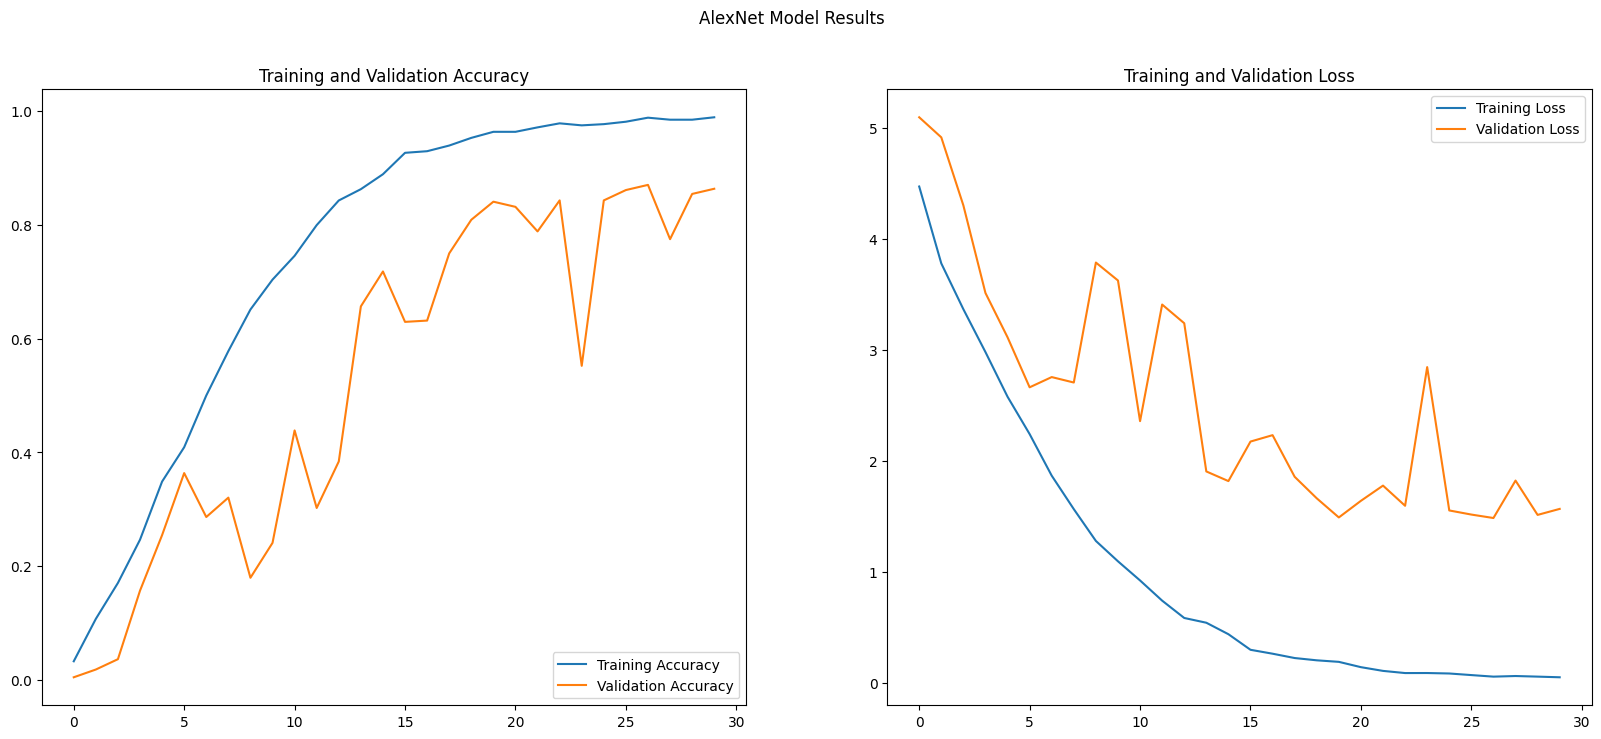

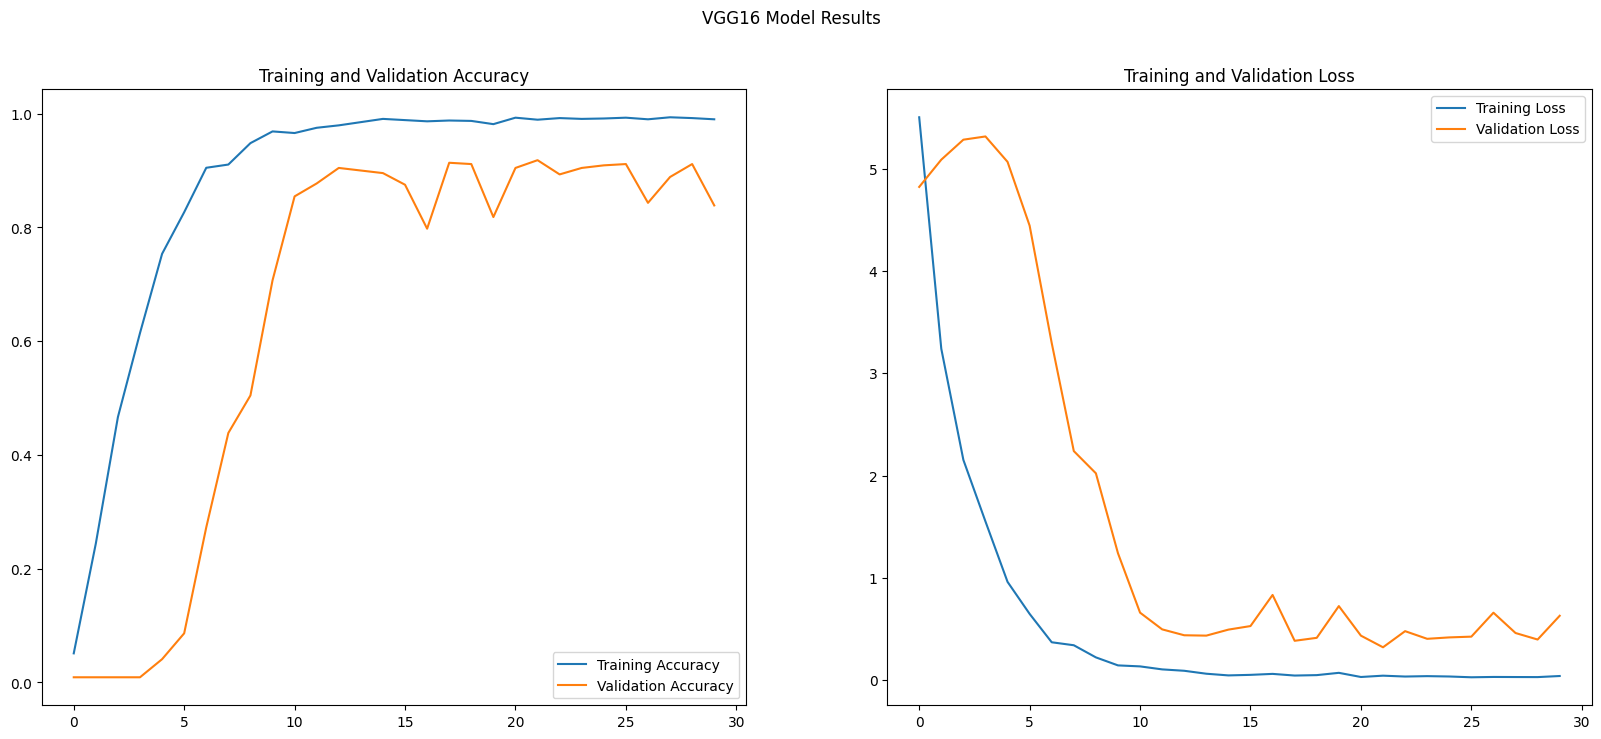

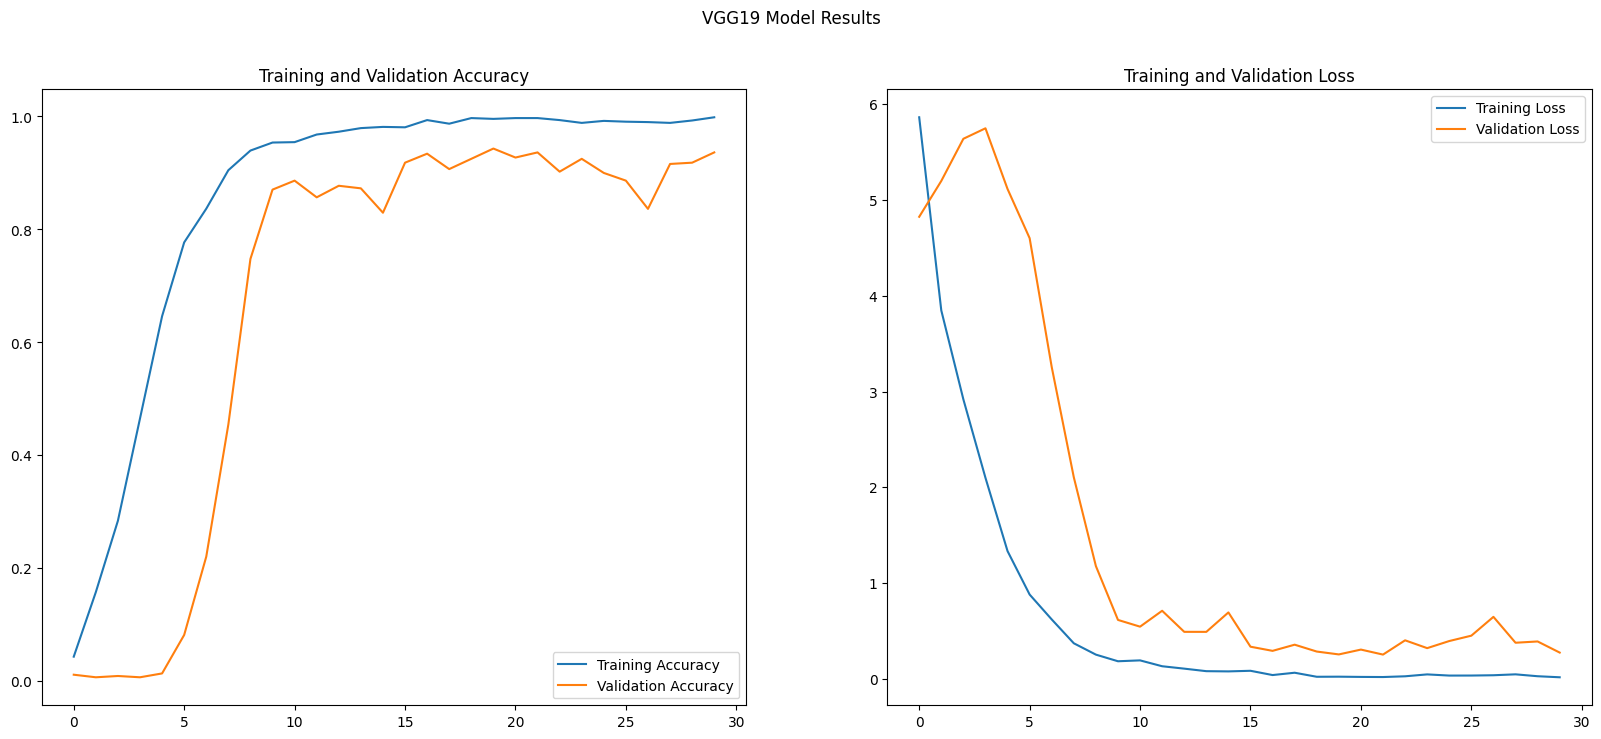

In [14]:
for name, history in model_histories.items():
    plot_model_performance(name, history)

In [15]:
model_results = {}

for name, model in models.items():
    model_results[name] = model.evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {model_results[name][1]*100:.2f}%")
    print(f"Test loss: {model_results[name][0]:.4f}", end = '\n\n')


11/11 [==============================] - 2s 32ms/step - loss: 0.1495 - accuracy: 0.9602
AlexNet Model Results:
Test accuracy: 96.02%
Test loss: 0.1495

11/11 [==============================] - 2s 60ms/step - loss: 0.1691 - accuracy: 0.9602
VGG16 Model Results:
Test accuracy: 96.02%
Test loss: 0.1691

11/11 [==============================] - 2s 66ms/step - loss: 0.0252 - accuracy: 0.9943
VGG19 Model Results:
Test accuracy: 99.43%
Test loss: 0.0252



Saving models and their training histories

In [16]:
# for name, model in models.items():
#     model.save(f'Saved Models/VERA/{name}-{model_results[name][1]*100:.2f}%.keras')
#     print(f'Saved {name} Model')


# for name, history in model_histories.items():
#     with open(f'Model Histories/VERA/{name}-{model_results[name][1]*100:.2f}%.json', 'w') as json_file:
#         json.dump(history.history, json_file)


## Loading trained model

In [26]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [27]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/VERA/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 2200 files belonging to 110 classes.
Using 1760 files for training.
Using 440 files for validation.

Total number of samples in train_dataset: 1408 (44 batches of 32)
Total number of samples in validation_dataset: 448 (14 batches of 32)
Total number of samples in test_dataset: 352 (11 batches of 32)


In [28]:
alexnet_model = keras.models.load_model('Saved Models/VERA/AlexNet-98.86%.keras')
vgg16_model = keras.models.load_model('Saved Models/VERA/VGG16-94.89%.keras')
vgg19_model = keras.models.load_model('Saved Models/VERA/VGG19-97.44%.keras')

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Text(0.5, 1.0, 'Predicted Class: 001-M\nActual Class: 001-M')

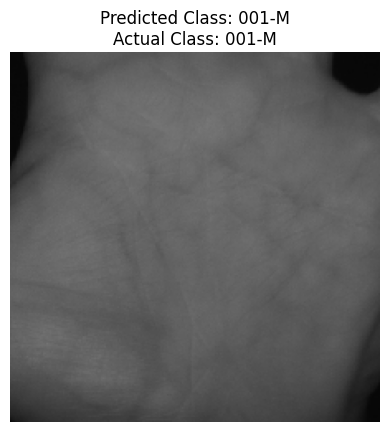

In [ ]:
class_to_test = 1 # Try any number from 1 to 110

img = keras.utils.load_img(
    f"Datasets/VERA/{class_names[class_to_test-1]}/01/{class_to_test:03d}_L_1_1.png", target_size=(224, 224)
)
plt.imshow(img)
plt.axis('off')

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

plt.title(f'Predicted Class: {class_names[prediction]}\nActual Class: {class_names[class_to_test-1]}')

In [ ]:
def decision_level_fusion_paper(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            # Assign weights based on correct or incorrect recognition
            weight_alexnet = 1 if prediction_alexnet == label else 0
            weight_vgg16 = 1 if prediction_vgg16 == label else 0
            weight_vgg19 = 1 if prediction_vgg19 == label else 0

            # Calculate the final decision
            final_decision = weight_alexnet + weight_vgg16 + weight_vgg19 

            # Update accuracy metrics
            correct_predictions += 1 if final_decision >= 2 else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

paper_fusion_accuracy = decision_level_fusion_paper(test_dataset)
print(f"Accuracy: {paper_fusion_accuracy:.2%}")


Evaluating Dataset With Decision Fusion: 100%|██████████| 11/11 [01:08<00:00,  6.22s/batch]

Accuracy: 98.86%


In [ ]:
def decision_level_fusion_improved(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Improved Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()


            predictions_list = [prediction_alexnet, prediction_vgg16, prediction_vgg19]

            joint_decision = max(set(predictions_list), key=predictions_list.count)

            # Update accuracy metrics
            correct_predictions += 1 if joint_decision == label else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

improved_fusion_accuracy = decision_level_fusion_improved(test_dataset)
print(f"Test Accuracy: {improved_fusion_accuracy:.2%}")


Evaluating Dataset With Improved Decision Fusion: 100%|██████████| 11/11 [01:06<00:00,  6.02s/batch]

Test Accuracy: 99.15%


In [ ]:
y = [model.evaluate(test_dataset, verbose=0)[1] for model in [alexnet_model, vgg16_model, vgg19_model]]
y.append(paper_fusion_accuracy)
y.append(improved_fusion_accuracy)

Text(0.5, 1.0, 'VERA Results Comparison')

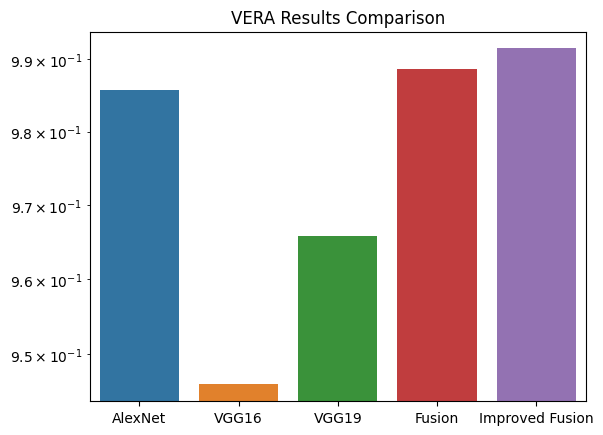

In [ ]:
import seaborn as sns

plt.yscale('log')
sns.barplot(y=y, x=['AlexNet', 'VGG16', 'VGG19', 'Fusion', 'Improved Fusion'])
plt.title('VERA Results Comparison')

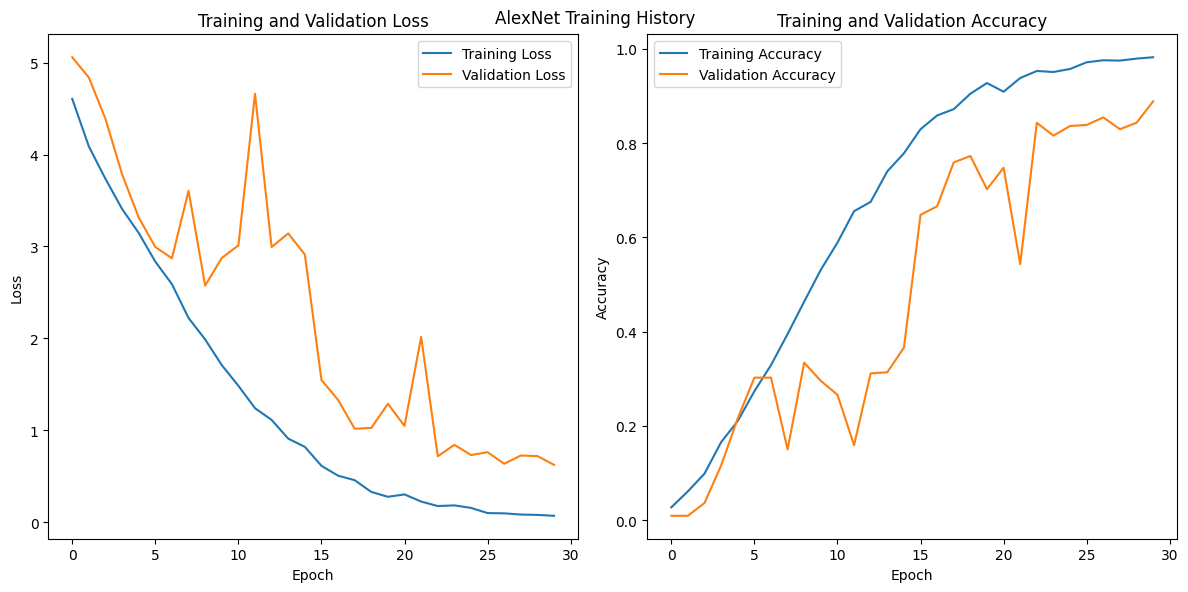

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/AlexNet-98.86%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('AlexNet Training History')
plt.show()


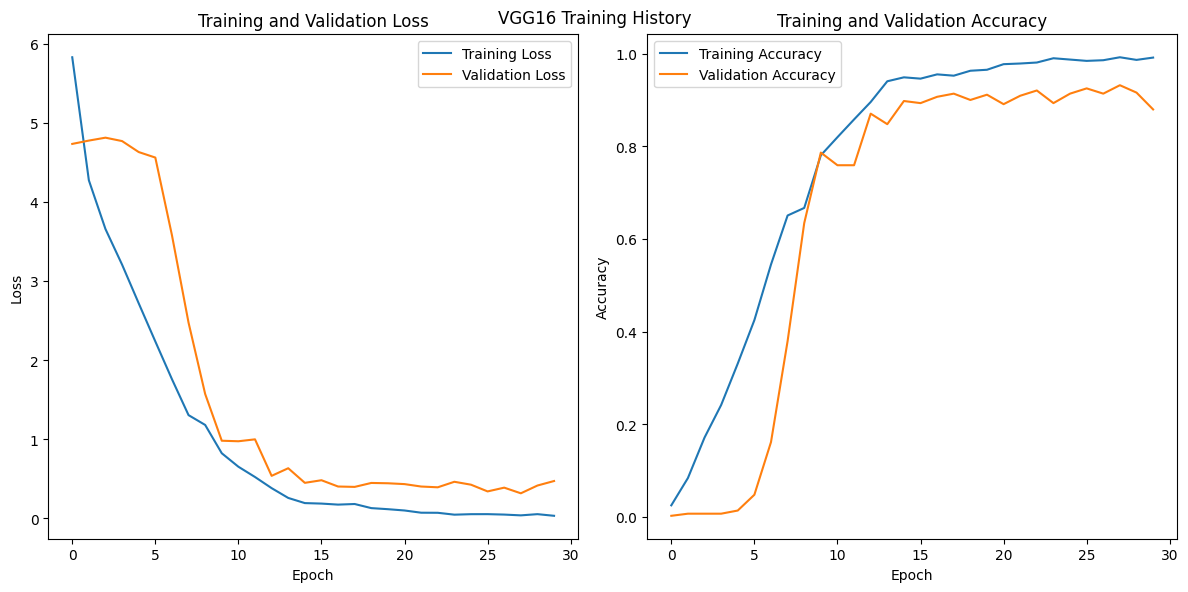

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/VGG16-94.89%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG16 Training History')
plt.show()


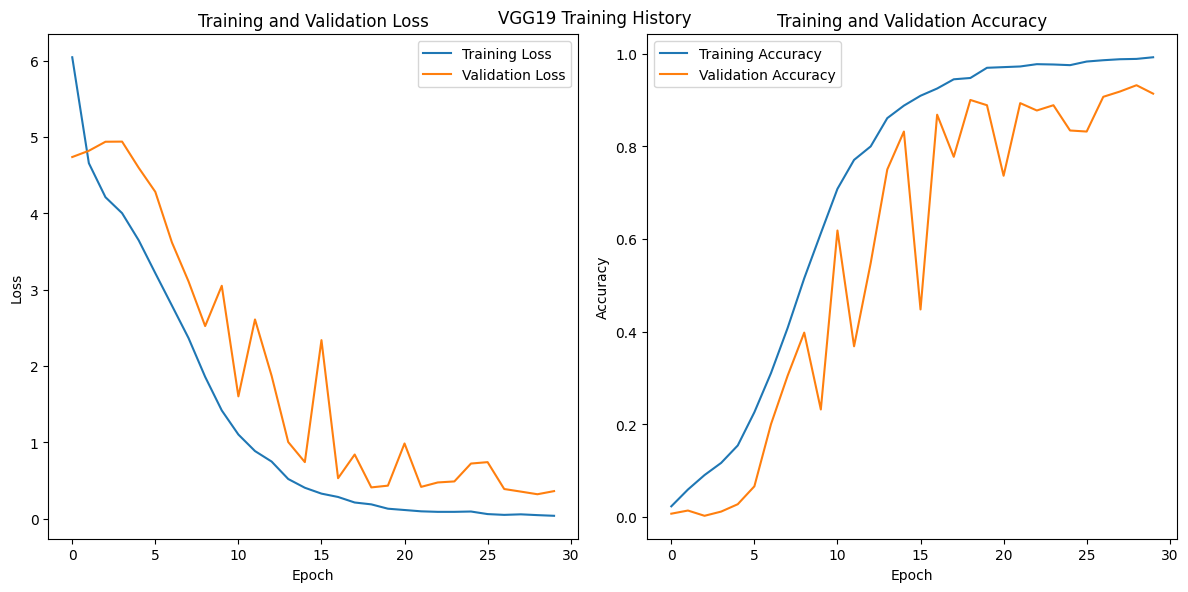

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/VERA/VGG19-99.43%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('VGG19 Training History')
plt.show()
